In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from phathom.phenotype import celltype
from phathom import io
from phathom import utils
from phathom import plotting
from phathom.synthetic import points_to_binary
import tifffile

In [2]:
%matplotlib notebook

In [3]:
working_dir = '/media/jswaney/SSD EVO 860/organoid_phenotyping/20181210_eF9_A34_2/'

# Set parameters on test images

In [4]:
syto16_path = 'syto16.zarr/1_1_1'

syto16_zarr = io.zarr.open(os.path.join(working_dir, syto16_path))
syto16_zarr.shape

(646, 2290, 2361)

In [16]:
# extract test patch
shape = np.array((256, 256, 256))
start = np.array((200, 500, 500))

stop = start + shape

syto16_test = utils.extract_box(syto16_zarr, start, stop)
syto16_test.shape

(256, 256, 256)

<IPython.core.display.Javascript object>


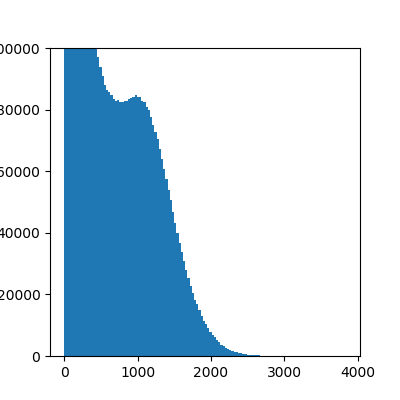

In [17]:
plt.figure(figsize=(4, 4))
plt.hist(syto16_test.ravel(), bins=128)
plt.ylim([0, 100000])
plt.show()

<IPython.core.display.Javascript object>


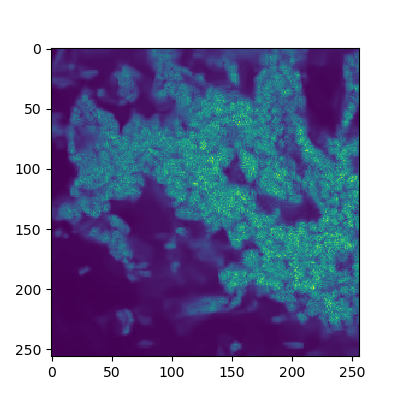

In [18]:
plt.figure(figsize=(4, 4))
plt.imshow(syto16_test[200])
plt.show()

In [19]:
sigma = (1.2, 2.0, 2.0)
steepness = 4000
offset = -0.0001
I0 = 500
stdev = 1e-5

prob = celltype.nucleus_probability(syto16_test, sigma, steepness, offset, I0, stdev)

<IPython.core.display.Javascript object>


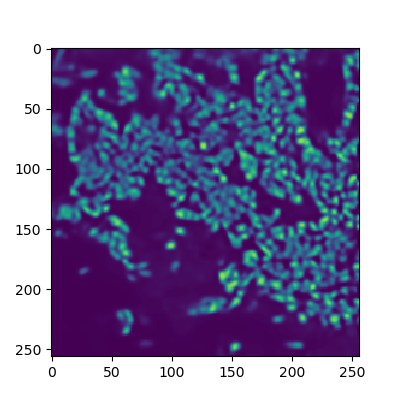

In [21]:
plt.figure(figsize=(4, 4))
plt.imshow(prob[200], clim=[0, 1])
plt.show()

In [22]:
prob_path = 'nuclei_probability.zarr'

min_intensity = 500
chunks = (64, 64, 64)
min_dist = 2
prob_thresh = 0.2
overlap = 4
nb_workers = 1

# (64, 128, 128) chunk shape causes GPU Runtime error???
# Maybe calculate the probability in small stacks rather than chunks

prob_output = io.zarr.new_zarr(os.path.join(working_dir, prob_path), 
                               syto16_zarr.shape, 
                               syto16_zarr.chunks,
                               np.float32)

results = celltype.detect_nuclei_parallel(syto16_zarr, 
                                          sigma=sigma, 
                                          min_intensity=min_intensity,
                                          steepness=steepness, 
                                          offset=offset,
                                          I0=I0,
                                          stdev=stdev,
                                          prob_thresh=prob_thresh,
                                          min_dist=min_dist,
                                          chunks=chunks,
                                          overlap=overlap,
                                          nb_workers=nb_workers,
                                          prob_output=prob_output)
centers_list = [r for r in results if r is not None]

100%|██████████| 14652/14652 [12:45<00:00, 19.14it/s] 


<IPython.core.display.Javascript object>


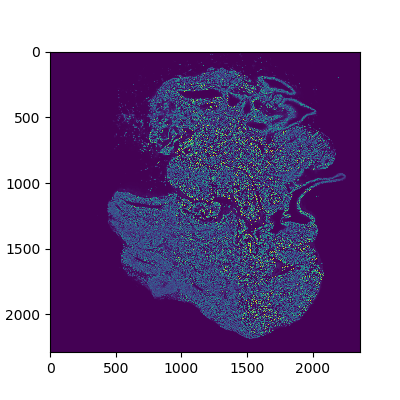

In [33]:
plt.figure(figsize=(4, 4))
plt.imshow(prob_output[350])  # check that the probability map was saved properly
plt.show()

In [ ]:
tifffile.imsave(os.path.join(working_dir, 'prob_map.tif'), prob_output[21].astype(np.float32))  # Aside: save detections and prob_map as tif

In [ ]:
tifffile.imsave(os.path.join(working_dir, 'nuclei_img.tif'), syto16_zarr[21])

In [24]:
centers = np.vstack(centers_list)
centers.shape

(1556799, 3)

<IPython.core.display.Javascript object>


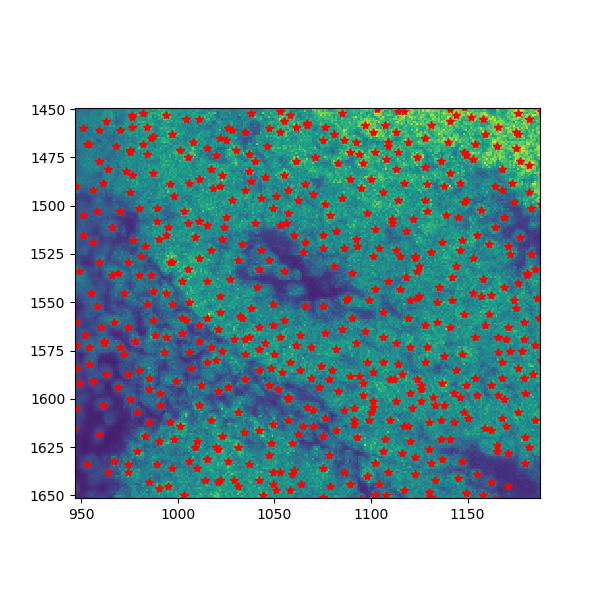

In [34]:
plt.figure(figsize=(6, 6))
plotting.zprojection(syto16_zarr, centers, zlim=[350, 356])

In [28]:
centers_img = points_to_binary(tuple(centers.T), 
                               syto16_zarr.shape,
                               size=3)

100%|██████████| 1556799/1556799 [00:15<00:00, 103561.24it/s]


In [29]:
tifffile.imsave(os.path.join(working_dir, 'centers.tif'), centers_img, compress=1)

In [ ]:
plotting.plot_pts(centers, alpha=0.01)

# Save the nuclei centers

In [30]:
centers_path = 'centers.npy'

np.save(os.path.join(working_dir, centers_path), centers)

In [ ]:
centers = np.load(os.path.join(working_dir, 'centers.npy'))

In [ ]:
data = tifffile.imread(os.path.join(working_dir, 'syto16.tif'))

In [ ]:
data.shape

In [ ]:
h = plt.hist(data.flatten(), bins=256, range=[0, 4095])
plt.show()